# Setup
This notebook will explore and evaluate the performance for `GPT-4-Turbo`, `DeepSeek-Coder-33B-Instruct`, `OpenCodeInterpreter-DS-33B`, `GPT-3.5-Turbo`, `WizardCoder-33B-V1.1`, `MagiCoder-S-DS-6.7B`, `CodeLLama-70B-Instruct`, `Gemini Pro 1.0` and`Codex` across:

* MAINTAINABILITY
* RELIABILITY
* SECURITY 
* PERFORMANCE EFFICIENCY

# Setup
Importing libraries, creating helper functions and defining plotting palettes

In [1]:
# Library Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dataframe_image as dfi

# Load sheet helper function
load_sheet = lambda x: pd.read_excel('results.xlsx', sheet_name=x)

In [2]:
### Plotting helpers
prompt_palette = {'short': '#bad7f5', 'medium': '#73afeb', 'long': '#004f9e', 'average':'gray'}

# Model name transformer for plotting
model_name_transformer = {'wizardcoder': 'WiCo',
                          'gpt-35-turbo': 'GPT35T',
                          'gpt-4-turbo': 'GPT4T',
                          'codellama': 'CLLam',
                          'opencodeinterpreter': 'OpCoInt',
                          'magicoder': 'MaCo',
                          'deepseeker-coder': 'DeSeCo',
                          'codex':'CoX',
                          'gemini': 'GeMi',
                          'baseline': 'Base'
                          }

colors = ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6", 'grey']
model_color_mapper = dict(zip(model_name_transformer.values(), colors))

# Data Loading

### Preprocessing Function

In [3]:
def dataframe_preprocessing(df0):
    # Copy the dataframe
    df = df0.copy()

    # Values with 0 values in any of the columns other than model and prompt with 0.01
    zerozero_one = ['errors', 'warnings', 'refactor', 'convention', 'pylint_score', 'security_low', 'max_complexity']# Standardize the columns

    # LOC normalization is also applied here as it is the same metrics
    for col in zerozero_one:
        if col != 'max_complexity':
            df[col] = df[col].apply(lambda x: 0.01 if x == 0 else x)

        if col != "security_low":
            df[col] = df[col] / df['loc']

    # Method normalization
    df['sloc_to_methods'] = df['sloc'] / df['number_of_methods']

    # Divide by maximum
    max_norms = zerozero_one + ['max_complexity', 'comments_to_loc', 'sloc_to_methods', 'memory_usage', 'multi_and_comments_to_loc']
    for col in max_norms:
        df[col] = df[col] / max(df[col])

    # Colummns with natural scales
    cols_natural_scale = {
        'mi': 100,
        'pylint_score': 10,
        'cpu':100}

    for col, scale in cols_natural_scale.items():
        df[col] = df[col] / scale

    # Inverse columns
    inverse = ['errors', 'cpu', 'warnings', 'refactor', 'convention', 'halstead_bugs', 'security_high', 'security_low', 'security_medium', 'memory_usage', 'max_complexity']
    for col in inverse:
        if df[col].sum() == len(df):
            continue
        df[col] = 1 - df[col]

    # Replacing model names with shorter names
    df['model'] = df['model'].apply(lambda x: model_name_transformer[x])

    return df



In [54]:
df['performance_composite '] = (df['cpu'] * 0.5) + (df['memory_usage'] * 0.5)
df['maintainability_composite'] = ((df['sloc_to_methods'] * 0.5 * 0.33) +
                                          (df['multi_and_comments_to_loc'] * 0.5 * 0.33) +
                                          (df['mi'] * 0.33) +
                                          (df['refactor'] * 0.5 * 0.33) +
                                          (df['convention'] * 0.5 * 0.33))
df['reliability_composite'] = df['errors'] * 0.25 + df['halstead_bugs'] * 0.25 + df['max_complexity'] * 0.25 + df['warnings'] * 0.25
df['security_composite'] = (df['security_low'] * 1/3) + (df['warnings'] * 1/3) + (df['errors'] * 1/3)

df['composite'] = (df['performance_composite '] + df['maintainability_composite'] + df['reliability_composite'] + df['security_composite']) / 4

In [4]:
# Metrics for each category
security_metrics = ['security_low', 'warnings', 'errors']
reliability_metrics = ['errors', 'warnings','max_complexity','halstead_bugs']
efficiency_metrics = ['cpu', 'memory_usage']
maintainability_metrics = ['mi','refactor','convention','comments_to_loc','sloc','sloc_to_methods', 'multi_and_comments_to_loc', 'halstead_effort']

# Domain parser
domain = {
    'attention': 'Machine Learning',
    'convolution': 'Machine Learning',
    'pca': 'Machine Learning',
    'huffman': 'Data Processing',
    'rabin-karp': 'Data Processing',
    'quick_sort': 'HPC',
    'monte_carlo_simulation': 'HPC',
    'page_rank': 'Data Processing',
    'strassen': 'HPC'
}

domain_palette = {
    'Machine Learning': 'red',
    'Data Processing': 'blue',
    'HPC': 'green'
}

### Loading data 

In [5]:
# Loading all data
df = pd.DataFrame()

# Loop through each sheet
for sheet in pd.ExcelFile('results.xlsx').sheet_names:

    # Skip the first sheet, it's empty
    if sheet == "Sheet":
        continue
    else:
        # Load the sheet
        df0 = load_sheet(sheet)

        # Add the algorithm column
        df0['algorithm'] = sheet
        # Concatenate the dataframes
        df = pd.concat([df, dataframe_preprocessing(df0.copy())]).groupby(['model','prompt', 'algorithm']).agg(np.mean).reset_index()


# Add average
average_df = df.groupby(['model', 'algorithm']).agg(np.mean).reset_index()
average_df['domain'] = average_df['algorithm'].apply(lambda x: domain[x])
average_df['prompt'] = 'average'

# Concatenate the dataframes
df['domain'] = df.algorithm.apply(lambda x: domain[x])
df_raw = pd.concat([df, average_df])

# Create a domain dataframe, averaging the values for each domain
domain_df = df_raw.groupby(['model', 'prompt', 'domain']).agg(np.mean).reset_index()

# Create a grouped dataframe for all domains
df = df_raw.groupby(['model', 'prompt']).agg(np.mean).reset_index()

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_22550/2122065192.py:21: FutureWarning: The operation <function mean at 0x10702eac0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  average_df = df.groupby(['model', 'algorithm']).agg(np.mean).reset_index()
/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_22550/2122065192.py:30: FutureWarning: The operation <function mean at 0x10702eac0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  domain_df = df_raw.groupby(['model', 'prompt', 'domain']).agg(np.mean).reset_index()
/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_22550/2122065192.py:33: FutureWarning: The operation <function mean at 0x10702eac0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these 

#### Paritionining

In [6]:
# Function to partition the dataframe
def partion(df, metrics, domain = False):
    if domain:
        also_include = ['domain']
    else:
        also_include = []
    always_include = ['model','prompt'] + also_include
    return df[always_include + metrics]

# Maintainability

In [122]:
# Partition dataframes for maintainability
df_maintainability = partion(df, maintainability_metrics)
df_domain_maintainability = partion(domain_df, maintainability_metrics, domain=True)

### Domain Exploration

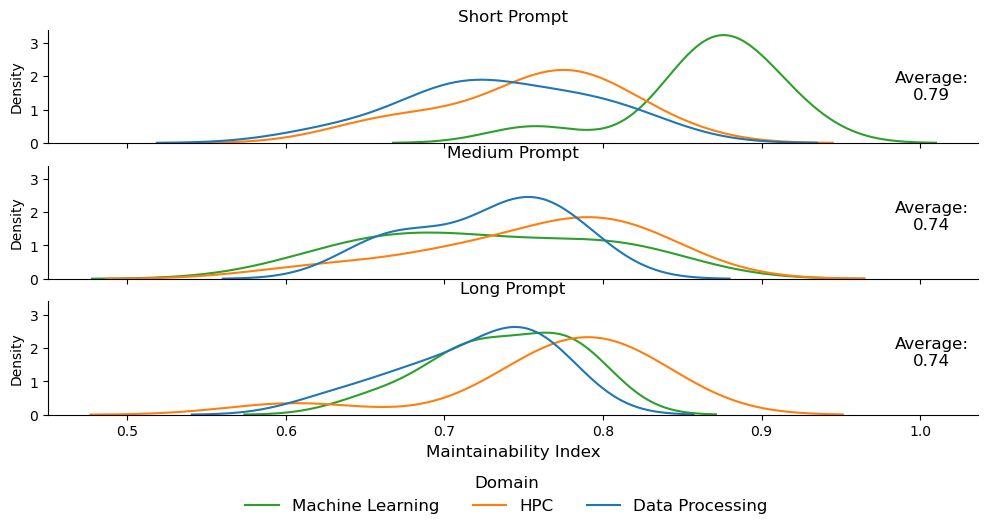

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_maintainability[df_domain_maintainability.prompt == prompt], x='mi', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Maintainability Index', fontsize=12)
    axs[i].text(0.95, distance, f"Average:\n{df_domain_maintainability[df_domain_maintainability.prompt == prompt].mi.mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

Evaluating maintianbility index across the domains seperately we see that the models pretty average produce pretty decent maintainability inde in the upper half, with 0.7 - 0.8, with the distributions being pretty similar across each domain. This behavior is a relevant observation given implying the models are quite capable of adopting domain specific blablabla...

### Model Exploration

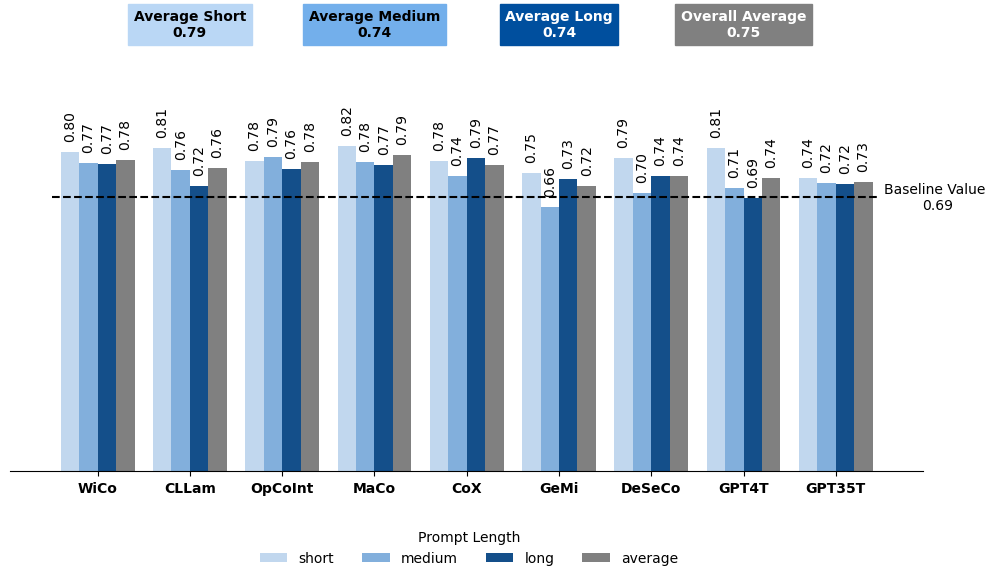

In [11]:
# Catplot
g = sns.catplot(data=df_maintainability[df_maintainability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='mi',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                errorbar=('ci', False)
                )

baseline_value = df_maintainability[df_maintainability.model == 'Base']['mi'].values[0]
short_average = df_maintainability[df_maintainability.prompt == 'short']['mi'].mean()
medium_average = df_maintainability[df_maintainability.prompt == 'medium']['mi'].mean()
long_average = df_maintainability[df_maintainability.prompt == 'long']['mi'].mean()
overall_average = df_maintainability['mi'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


In [12]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_maintainability.pivot(index='model',columns='prompt',values='mi')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
dfi.export(bugs_style, 'results_output/mi.png')

As expected after seeing the distributions we see a pretty uniform maintainability index, with most models remaining pretty consistent across all prompts, even beating the established baseline for most solutions. Overall, Magicoder, WizardCoder and OpenCodeInterpreter comes out slightly ahead, with an an average performance 10-11% above the baseline. While no model significantly underperformn, we see that Gemini achieves the overall poorest score for their medium prompt solutions, and on average the model similarly slightly underperforms, albeit remaining above the established baseline. 

#### Code Style Composite Score

In [ ]:
# Catplot
g = sns.catplot(data=df_maintainability[df_maintainability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='convention',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=False
                )

baseline_value = df_maintainability[df_maintainability.model == 'Base']['convention'].values[0]
short_average = df_maintainability[df_maintainability.prompt == 'short']['convention'].mean()
medium_average = df_maintainability[df_maintainability.prompt == 'medium']['convention'].mean()
long_average = df_maintainability[df_maintainability.prompt == 'long']['convention'].mean()
overall_average = df_maintainability[df_maintainability.prompt == 'average']['convention'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)
#g.figure.axes.rcParams['axes.titleweight'] = 'bold'
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


#### Python Style Adherence

In [ ]:
# Catplot
g = sns.catplot(data=df_maintainability[df_maintainability.model != 'Base'].sort_values(by='prompt', ascending=False),
                kind='bar',
                x='model',
                y='refactor',
                hue='prompt',
                palette=prompt_palette,
                legend=False
                )

baseline_value = df_maintainability[df_maintainability.model == 'Base']['refactor'].values[0]
short_average = df_maintainability[df_maintainability.prompt == 'short']['refactor'].mean()
medium_average = df_maintainability[df_maintainability.prompt == 'medium']['refactor'].mean()
long_average = df_maintainability[df_maintainability.prompt == 'long']['refactor'].mean()
overall_average = df_maintainability[df_maintainability.prompt == 'average']['refactor'].mean()

g.set_titles('refactor')
# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


In [101]:
data = df_raw[['domain','prompt','loc']].groupby(['domain', 'prompt']).agg(np.mean).reset_index()


In [103]:
data = df_raw[['domain','prompt','loc']].groupby(['domain', 'prompt']).agg(np.mean).reset_index()

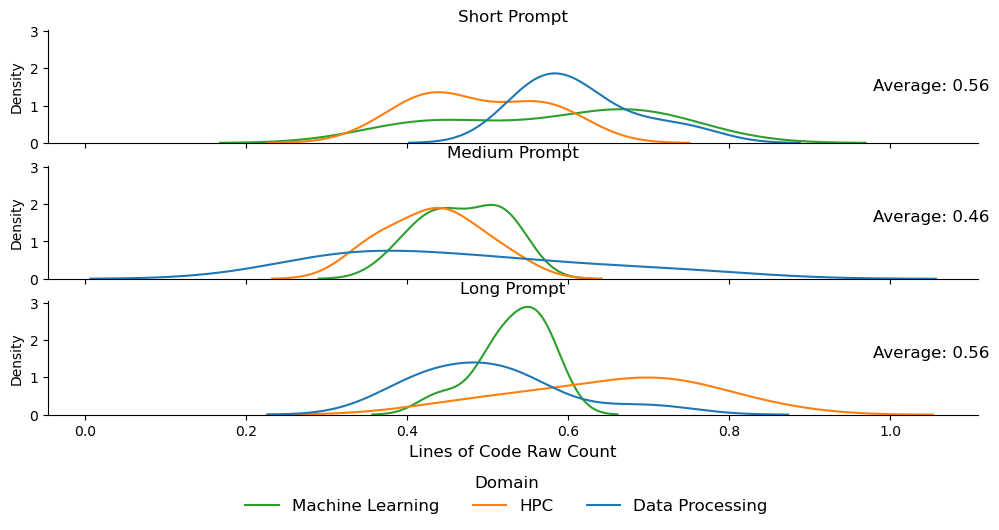

In [111]:
#df_domain_maintainability = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_maintainability[df_domain_maintainability.prompt == prompt], x='sloc_to_methods', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Lines of Code Raw Count', fontsize=12)
    axs[i].text(0.95, distance, f"Average: {df_domain_maintainability[df_domain_maintainability.prompt == prompt]['sloc_to_methods'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

del df_domain_maintainability

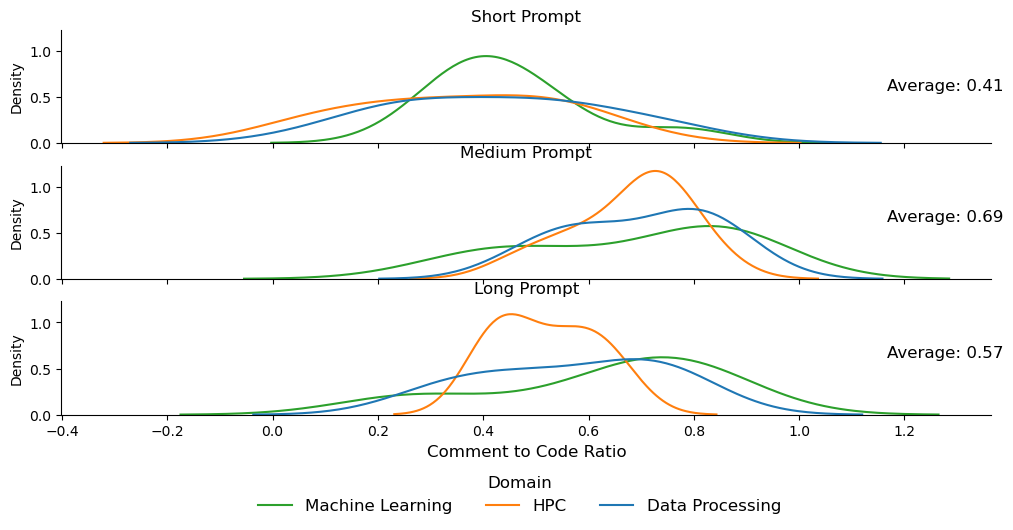

In [62]:
fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_maintainability[df_domain_maintainability.prompt == prompt], x='multi_and_comments_to_loc', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Comment to Code Ratio', fontsize=12)
    axs[i].text(0.95, distance, f"Average: {df_domain_maintainability[df_domain_maintainability.prompt == prompt].multi_and_comments_to_loc.mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_maintainability[df_domain_maintainability.prompt == prompt], x='convention', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Code Convention Violations', fontsize=12)
    axs[i].text(0.95, distance, f"Average:\n{df_domain_maintainability[df_domain_maintainability.prompt == prompt].convention.mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

In [ ]:
g = sns.catplot(data=df_domain_maintainability[df_domain_maintainability.prompt != 'baseline'], y='refactor', x='domain', hue='prompt', kind='bar', ci=False, palette=prompt_palette, legend=False)


baseline_value = df_domain_maintainability[df_domain_maintainability.model == 'Base']['refactor'].values[0]
short_average = df_domain_maintainability[df_domain_maintainability.prompt == 'short']['refactor'].mean()
medium_average = df_domain_maintainability[df_domain_maintainability.prompt == 'medium']['refactor'].mean()
long_average = df_domain_maintainability[df_domain_maintainability.prompt == 'long']['refactor'].mean()
overall_average = df_domain_maintainability['refactor'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(5, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')
g.figure.axes[0].set_title('Code refactor Violations', fontsize=12,  y=1.2, fontweight='bold')
g.figure.axes[0].set_ylim(0,1)

# Add average lines
g.figure.axes[0].text(-0.2, 1.05, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(1, 1.05, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(2.2, 1.05, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -0.5, 2.5, colors='black', linestyles='--')
g.figure.axes[0].text(2.7, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

g.figure.legend(bbox_to_anchor=(.55, -0.1), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

plt.show()

In [ ]:
g = sns.catplot(data=df_domain_maintainability[df_domain_maintainability.prompt != 'baseline'], y='refactor', x='domain', hue='prompt', kind='bar', ci=False, palette=prompt_palette, legend=False)


baseline_value = df_domain_maintainability[df_domain_maintainability.model == 'Base']['refactor'].values[0]
short_average = df_domain_maintainability[df_domain_maintainability.prompt == 'short']['refactor'].mean()
medium_average = df_domain_maintainability[df_domain_maintainability.prompt == 'medium']['refactor'].mean()
long_average = df_domain_maintainability[df_domain_maintainability.prompt == 'long']['refactor'].mean()
overall_average = df_domain_maintainability['refactor'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(5, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')
g.figure.axes[0].set_title('Code refactor Violations', fontsize=12,  y=1.2, fontweight='bold')
g.figure.axes[0].set_ylim(0,1)

# Add average lines
g.figure.axes[0].text(-0.2, 1.05, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(1, 1.05, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(2.2, 1.05, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -0.5, 2.5, colors='black', linestyles='--')
g.figure.axes[0].text(2.7, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

g.figure.legend(bbox_to_anchor=(.55, -0.1), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

plt.show()

In [ ]:
# Catplot
g = sns.catplot(data=df_maintainability[df_maintainability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='mi',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                errorbar=('ci', False)
                )

baseline_value = df_maintainability[df_maintainability.model == 'Base']['mi'].values[0]
short_average = df_maintainability[df_maintainability.prompt == 'short']['mi'].mean()
medium_average = df_maintainability[df_maintainability.prompt == 'medium']['mi'].mean()
long_average = df_maintainability[df_maintainability.prompt == 'long']['mi'].mean()
overall_average = df_maintainability['mi'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


In [67]:
df_maintainability.columns

Index(['model', 'prompt', 'mi', 'refactor', 'convention', 'comments_to_loc',
       'sloc', 'sloc_to_methods', 'multi_and_comments_to_loc',
       'halstead_effort'],
      dtype='object')

In [68]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_maintainability.pivot(index='model',columns='prompt',values='multi_and_comments_to_loc')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
dfi.export(bugs_style, 'results_output/multi_and_comments_to_loc.png')

*Extra: Distribution of code violations for differnet algorthims in HPC*

In [ ]:
# Catplot
g = sns.catplot(data=df_maintainability[df_maintainability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='refactor',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                errorbar=('ci', False)
                )

baseline_value = df_maintainability[df_maintainability.model == 'Base']['refactor'].values[0]
short_average = df_maintainability[df_maintainability.prompt == 'short']['refactor'].mean()
medium_average = df_maintainability[df_maintainability.prompt == 'medium']['refactor'].mean()
long_average = df_maintainability[df_maintainability.prompt == 'long']['refactor'].mean()
overall_average = df_maintainability['refactor'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


In [ ]:
# Plotting convention error density for HPC

fig, axs = plt.subplots(figsize=(7, 4))

hpc_without_strassen = pd.concat([mcs,  quick_sort], axis=0).groupby(['model','prompt']).agg(np.mean).reset_index()

sns.kdeplot(data=strassen, x='convention',
             palette=prompt_palette,
             ax=axs,
             label='Strassen')

sns.kdeplot(data=quick_sort, x='convention',
             palette=prompt_palette,
             ax=axs,
             label='Quick Sort')

sns.kdeplot(data=mcs,
            x='convention', palette=prompt_palette,
            ax=axs,
            label='Monte Carlo Simulation')


axs.legend( frameon=False, loc='lower center', bbox_to_anchor=(0.50, 1), ncol=3)
axs.set_xlabel('Code Convention Score')


sns.despine(ax=axs)


#### General Code Statistics

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_71259/3694889470.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_71259/3694889470.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_71259/3694889470.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become 

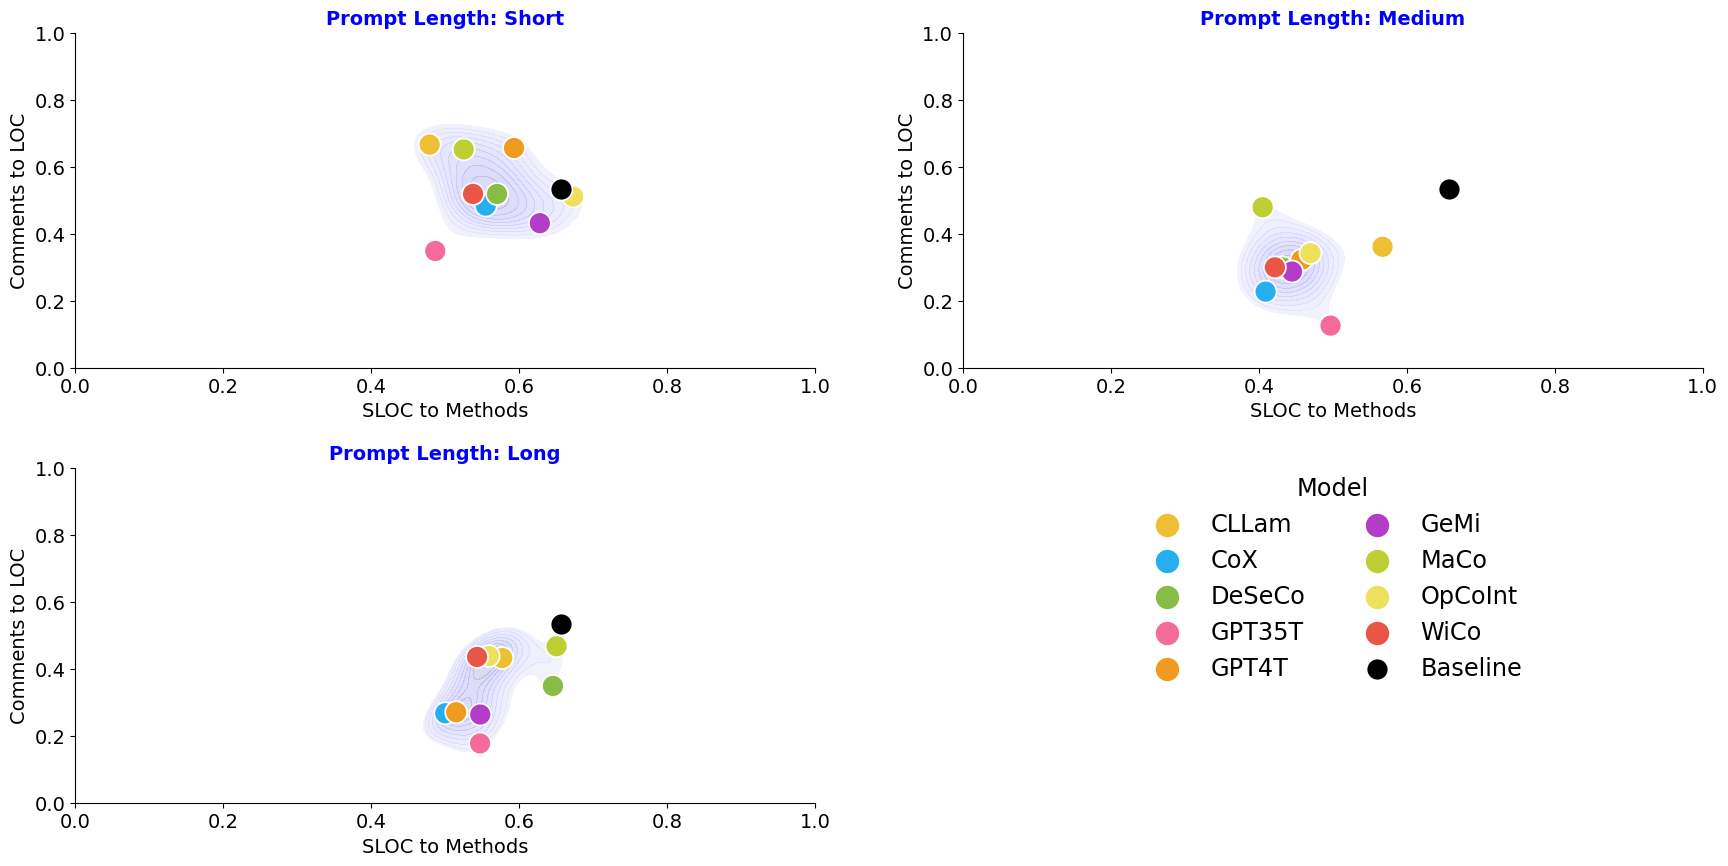

In [14]:
import matplotlib.ticker as ticker

# FILEPATH: /Users/rasmuskrebs/Documents/School/master_thesis/repo/results_visualization.ipynb
fig, axs = plt.subplots(2, 2, figsize=(21, 10))
axs = axs.flatten()


prompts = ['short', 'medium', 'long']

# Draw a contour plot to represent each bivariate density
for x, prompt in zip(list(range(3)), prompts):
    other_prompts = [p for p in prompts if p != prompt]
    axs[x].set_title(f'Prompt Length: {prompt.capitalize()}', fontsize=14, weight='bold', color='blue')
    sns.kdeplot(
        data=df_maintainability[-df_maintainability.prompt.isin(other_prompts + ['average', 'baseline'])],
        x="sloc_to_methods",
        y="comments_to_loc",
        color='blue',
        thresh=.4,
        linewidths=1,
        alpha=.2,
        ax=axs[x],
        #fill=True,
        shade=True,
    )
    sns.scatterplot(data=df_maintainability[df_maintainability.prompt == prompt],
                    x='sloc_to_methods', y='comments_to_loc', hue='model', s=250, ax=axs[x], palette=model_color_mapper)

    sns.scatterplot(data=df_maintainability[df_maintainability.prompt == 'baseline'],
                    x='sloc_to_methods', y='comments_to_loc', color='black',s=250,ax=axs[x], label='Baseline')

    axs[x].set_xlabel('SLOC to Methods', fontsize=14)
    axs[x].set_ylabel('Comments to LOC', fontsize=14)
    axs[x].tick_params(axis='both', which='major', labelsize=14)
    axs[x].yaxis.set_tick_params(labelbottom=True)
    axs[x].xaxis.set_tick_params(labelbottom=True)
    axs[x].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Set the number of ticks on the y-axis to 4
    #axs[x].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))  # Add percentage mark to y-axis
    axs[x].set_ylim(0, 1)
    axs[x].set_xlim(0, 1)

l = axs[0].legend(frameon=False,
              loc='lower center',
              ncol=2,
              fontsize='xx-large',
              bbox_to_anchor=(1.7, -1),
              title='Model',
              title_fontsize='xx-large')

for lh in l.legendHandles:
    lh.set_alpha(1)
    lh._sizes = [250]

axs[1].legend().remove()
axs[2].legend().remove()
sns.despine()
axs[3].axis('off')
#axs[1].set_xlabel('Code Convention Score', fontsize=14)

plt.subplots_adjust(hspace = 0.3)

plt.show()

#### Composite Scoring

Each of the three angles will be weighted equally, and then within each of the categories, the metrics are then weighted accordingly

In [112]:
# Breaking up the three parts to equal parts
maintainability_index = 0.33

refactor = 0.7 * 0.33
convention = 0.3 * 0.33

sloc_to_methods = 0.5 * 0.33
halstead_effort = 0.5 * 0.33

print(maintainability_index+refactor+convention+sloc_to_methods+halstead_effort)

0.99


In [137]:
df_maintainability['composite_score'] = ((df_maintainability['sloc_to_methods'] * 0.5 * 0.33) +
                                          (df_maintainability['multi_and_comments_to_loc'] * 0.5 * 0.33) +
                                          (df_maintainability['mi'] * 0.33) +
                                          (df_maintainability['refactor'] * 0.5 * 0.33) +
                                          (df_maintainability['convention'] * 0.5 * 0.33))

df_domain_maintainability['composite_score'] = ((df_domain_maintainability['sloc_to_methods'] * 0.5 * 0.33) +
                                          (df_domain_maintainability['multi_and_comments_to_loc'] * 0.5 * 0.33) +
                                          (df_domain_maintainability['mi'] * 0.33) +
                                          (df_domain_maintainability['refactor'] * 0.5 * 0.33) +
                                          (df_domain_maintainability['convention'] * 0.5 * 0.33))


/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_71259/1153812579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_maintainability['composite_score'] = ((df_maintainability['sloc_to_methods'] * 0.5 * 0.33) +
/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_71259/1153812579.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_domain_maintainability['composite_score'] = ((df_domain_maintainability['sloc_to_methods'] * 0.5 * 0.33) +


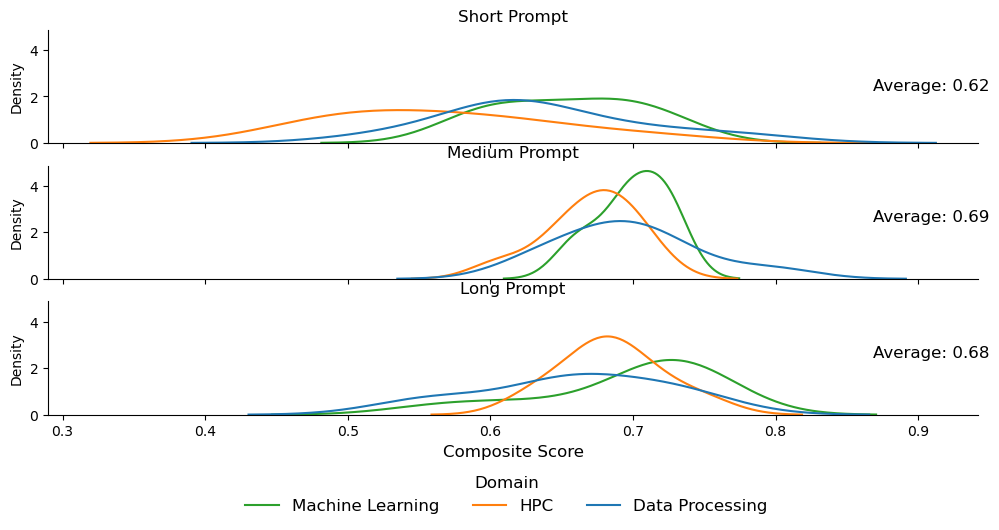

In [139]:
fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_maintainability[df_domain_maintainability.prompt == prompt], x='composite_score', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Composite Score', fontsize=12)
    axs[i].text(0.95, distance, f"Average: {df_domain_maintainability[df_domain_maintainability.prompt == prompt].composite_score.mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

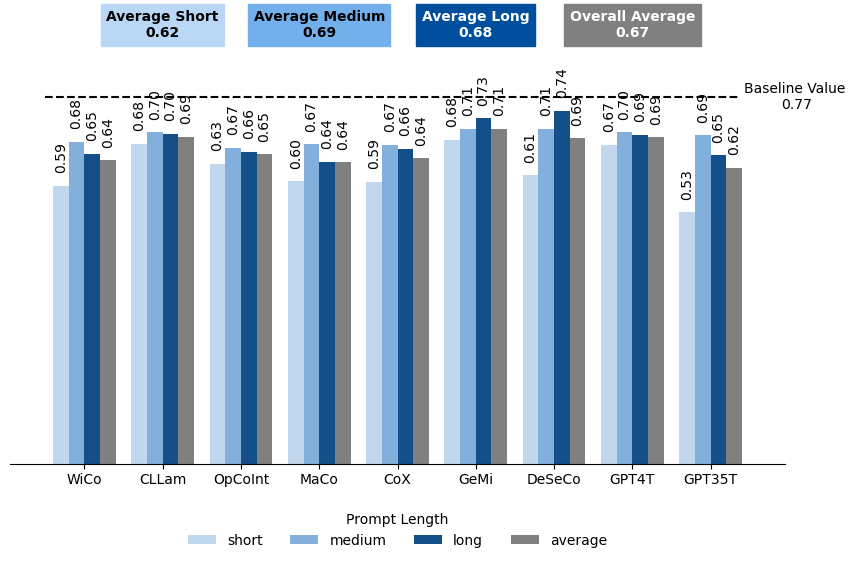

In [140]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.barplot(data=df_maintainability[(-df_maintainability.prompt.isin(['baseline'])) & (df_maintainability.model != 'Base')].sort_values(by='prompt', ascending=False),
            x='model', y='composite_score', hue='prompt', palette=prompt_palette)


baseline_value = df_maintainability[df_maintainability.model == 'Base']['composite_score'].values[0]
short_average = df_maintainability[df_maintainability.prompt == 'short']['composite_score'].mean()
medium_average = df_maintainability[df_maintainability.prompt == 'medium']['composite_score'].mean()
long_average = df_maintainability[df_maintainability.prompt == 'long']['composite_score'].mean()
overall_average = df_maintainability[df_maintainability.prompt == 'average']['composite_score'].mean()

# Removing y-axis
axs.set_ylabel('')
axs.set_yticks([])

# Format x-axis labels
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, ha='center')

# Add baseline line
axs.hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
axs.text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
axs.text(1, .9, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
axs.text(3, .9, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
axs.text(5, .9, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
axs.text(7, .9, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
axs.set_ylabel('')  # Remove y-axis label
axs.set_yticks([])  # Remove y-axis ticks
axs.set_xlabel('')  # Remove x-axis label

# Set legend position
axs.legend(bbox_to_anchor=(0.5, -0.25), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

sns.despine()
axs.spines['left'].set_visible(False)

# Add annotations to the bars
for p in axs.patches:
    axs.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')


plt.show()


# Performance Efficiency

In [7]:
# Partition dataframes for maintainability
df_performance = partion(df, efficiency_metrics)
df_domain_performance = partion(domain_df, efficiency_metrics, domain=True)

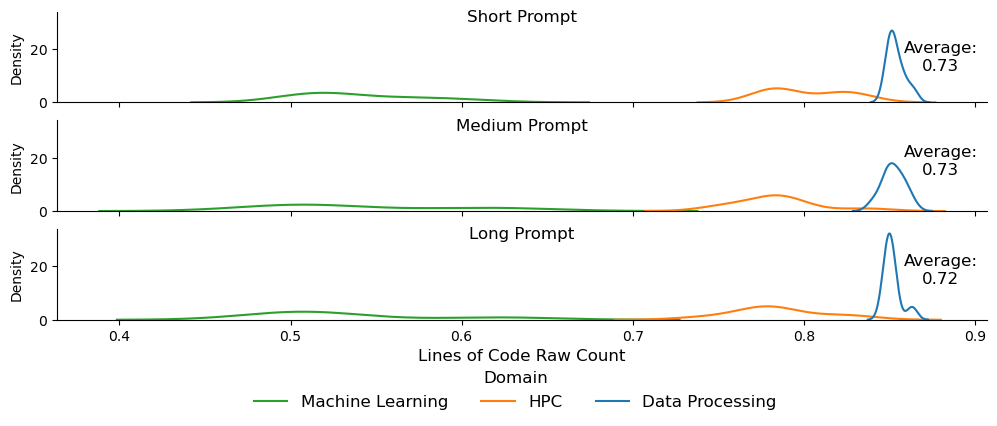

In [55]:
#df_domain_performance = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_performance[df_domain_performance.prompt == prompt], x='cpu', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light', y=0.8)
    axs[i].set_xlabel('Lines of Code Raw Count', fontsize=12)
    axs[i].text(0.95, distance, f"Average:\n{df_domain_performance[df_domain_performance.prompt == prompt]['cpu'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

In [36]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_performance.pivot(index='model',columns='prompt',values='cpu')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
# dfi.export(bugs_style, 'results_output/multi_and_comments_to_loc.png')

,short,medium,long,average,baseline
CLLam,0.73,0.72,0.73,0.73,0.73
CoX,0.72,0.71,0.71,0.71,0.73
DeSeCo,0.72,0.74,0.71,0.72,0.73
GPT35T,0.73,0.71,0.71,0.71,0.73
GPT4T,0.76,0.77,0.75,0.76,0.73
GeMi,0.72,0.71,0.73,0.72,0.73
MaCo,0.75,0.71,0.75,0.73,0.73
OpCoInt,0.73,0.75,0.70,0.73,0.73
WiCo,0.74,0.72,0.71,0.72,0.73
Average,0.73,0.73,0.72,0.73,0.73


In [68]:
df_raw[['model', 'domain','prompt','memory_usage']].groupby(['model', 'domain','prompt']).agg(np.mean).reset_index()

,model,domain,prompt,memory_usage
0,baseline,Data Processing,average,36.927083
1,baseline,Data Processing,baseline,36.927083
2,baseline,HPC,average,66.942708
3,baseline,HPC,baseline,66.942708
4,baseline,Machine Learning,average,179.369792
...,...,...,...,...
109,wizardcoder,HPC,short,36.536458
110,wizardcoder,Machine Learning,average,172.559028
111,wizardcoder,Machine Learning,long,163.671875
112,wizardcoder,Machine Learning,medium,180.432292


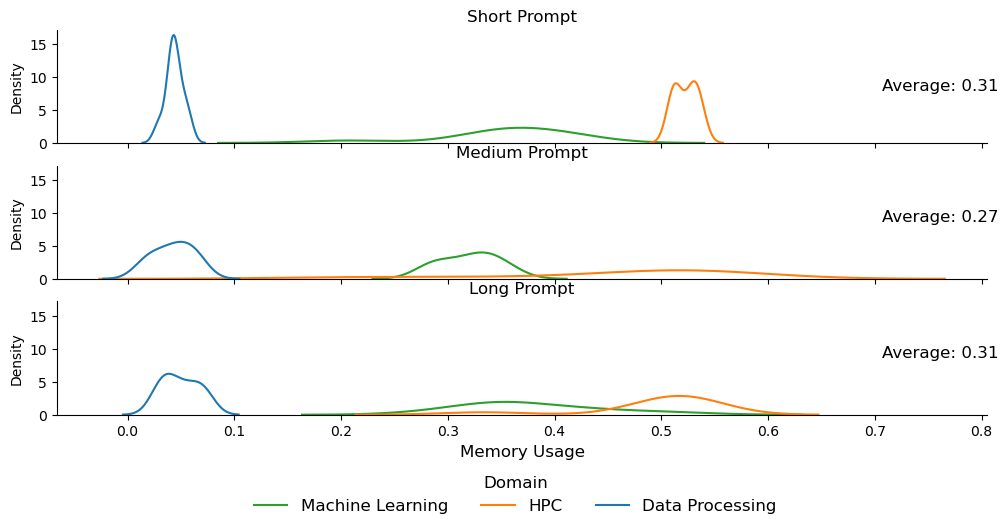

In [77]:
#df_domain_performance = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_performance[df_domain_performance.prompt == prompt], x='memory_usage', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light')
    axs[i].set_xlabel('Memory Usage', fontsize=12)
    axs[i].text(0.95, distance, f"Average: {df_domain_performance[df_domain_performance.prompt == prompt]['memory_usage'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

#### CPU Usage 

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_96291/1319901127.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(data=df_performance[df_performance.model != 'Base'].sort_values(by='prompt',ascending=False),


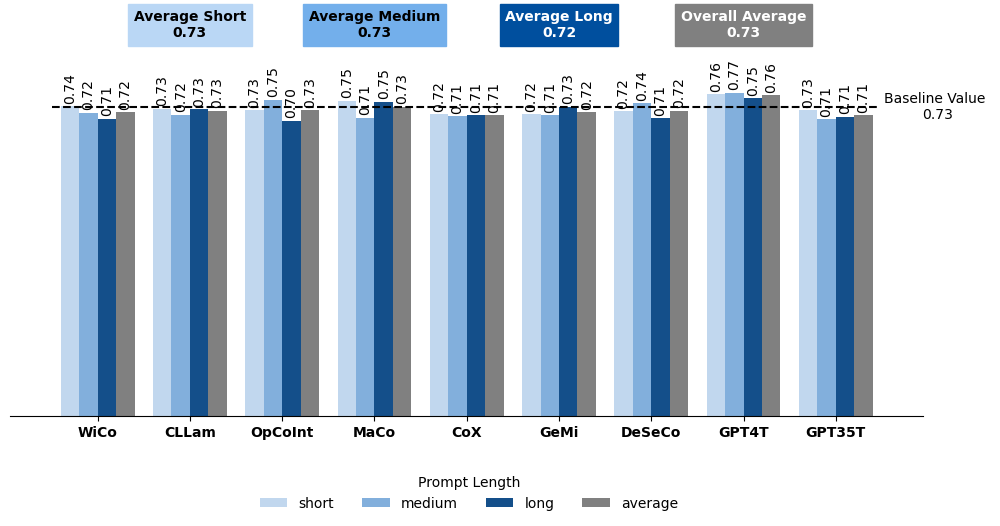

In [82]:
# Catplot
g = sns.catplot(data=df_performance[df_performance.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='cpu',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = df_performance[df_performance.model == 'Base']['cpu'].values[0]
short_average = df_performance[df_performance.prompt == 'short']['cpu'].mean()
medium_average = df_performance[df_performance.prompt == 'medium']['cpu'].mean()
long_average = df_performance[df_performance.prompt == 'long']['cpu'].mean()
overall_average = df_performance[df_performance.prompt == 'average']['cpu'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, .9, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, .9, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, .9, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, .9, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.01),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


#### Memory Usage

In [ ]:
# Catplot
g = sns.catplot(data=hpc_efficiency[hpc_efficiency.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='memory_usage',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = hpc_efficiency[hpc_efficiency.model == 'Base']['memory_usage'].values[0]
short_average = hpc_efficiency[hpc_efficiency.prompt == 'short']['memory_usage'].mean()
medium_average = hpc_efficiency[hpc_efficiency.prompt == 'medium']['memory_usage'].mean()
long_average = hpc_efficiency[hpc_efficiency.prompt == 'long']['memory_usage'].mean()
overall_average = hpc_efficiency[hpc_efficiency.prompt == 'average']['memory_usage'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 0.69, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 0.69, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 0.69, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 0.69, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


#### Composite

In [85]:
df_performance['composite_score'] = (df_performance['cpu'] * 0.5) + (df_performance['memory_usage'] * 0.5)
df_domain_maintainability['composite_score'] = ((df_domain_maintainability['sloc_to_methods'] * 0.5 * 0.33) +
                                          (df_domain_maintainability['multi_and_comments_to_loc'] * 0.5 * 0.33) +
                                          (df_domain_maintainability['mi'] * 0.33) +
                                          (df_domain_maintainability['refactor'] * 0.5 * 0.33) +
                                          (df_domain_maintainability['convention'] * 0.5 * 0.33))
reliability_composite = lambda x: x['errors'] * 0.25 + x['halstead_bugs'] * 0.25 + x['max_complexity'] * 0.25 + x['warnings'] * 0.25
df_security['security'] = (df_security['security_low'] * 1/3) + (df_security['warnings'] * 1/3) + (df_security['errors'] * 1/3)

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_96291/1668859758.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(data=df_performance[df_performance.model != 'Base'].sort_values(by='prompt',ascending=False),


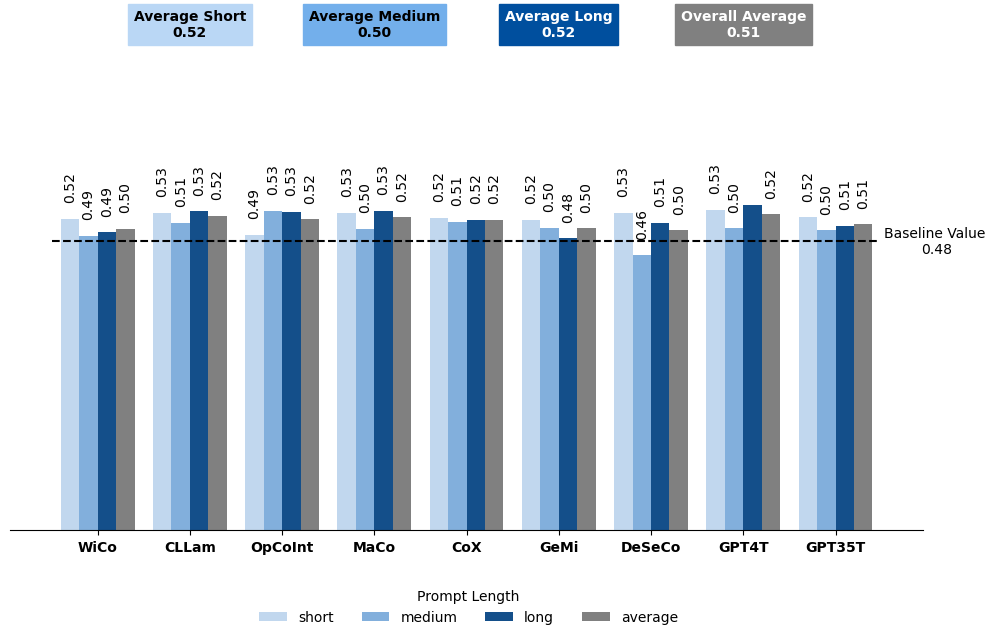

In [86]:
# Catplot
g = sns.catplot(data=df_performance[df_performance.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='composite_score',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = df_performance[df_performance.model == 'Base']['composite_score'].values[0]
short_average = df_performance[df_performance.prompt == 'short']['composite_score'].mean()
medium_average = df_performance[df_performance.prompt == 'medium']['composite_score'].mean()
long_average = df_performance[df_performance.prompt == 'long']['composite_score'].mean()
overall_average = df_performance[df_performance.prompt == 'average']['composite_score'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 0.82, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 0.82, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 0.82, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 0.82, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


# Security

In [38]:
# Partition dataframes for security
df_security = partion(df, security_metrics)
df_domain_security = partion(domain_df, security_metrics, domain=True)

In [46]:
df_domain_security['security'] = (df_domain_security['security_low'] * 1/3) + (df_domain_security['warnings'] * 1/3) + (df_domain_security['errors'] * 1/3)
df_security['security'] = (df_security['security_low'] * 1/3) + (df_security['warnings'] * 1/3) + (df_security['errors'] * 1/3)

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_22550/1410429663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_domain_security['security'] = (df_domain_security['security_low'] * 1/3) + (df_domain_security['warnings'] * 1/3) + (df_domain_security['errors'] * 1/3)
/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_22550/1410429663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security['security'] = (df_security['security_low'] * 1/3) + (df_security['warnings'] * 1/3) + (d

### Domain Exploration  

ValueError: Could not interpret value `domain` for parameter `hue`

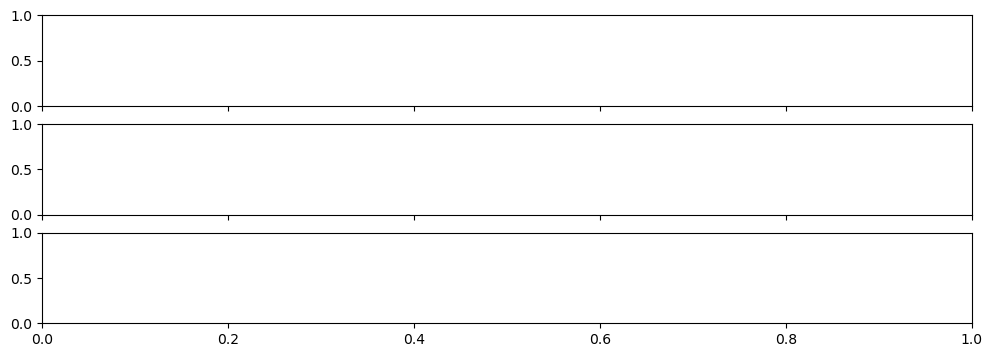

In [55]:
#df_domain_security = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df[df.prompt == prompt], x='security', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light', y=0.8)
    axs[i].set_xlabel('Security', fontsize=12)
    axs[i].text(0.95, distance, f"Average:\n{df[df.prompt == prompt]['security'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

### Model Exploration

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_22550/1063486090.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(data=df[df.model != 'Base'].sort_values(by='prompt',ascending=False),


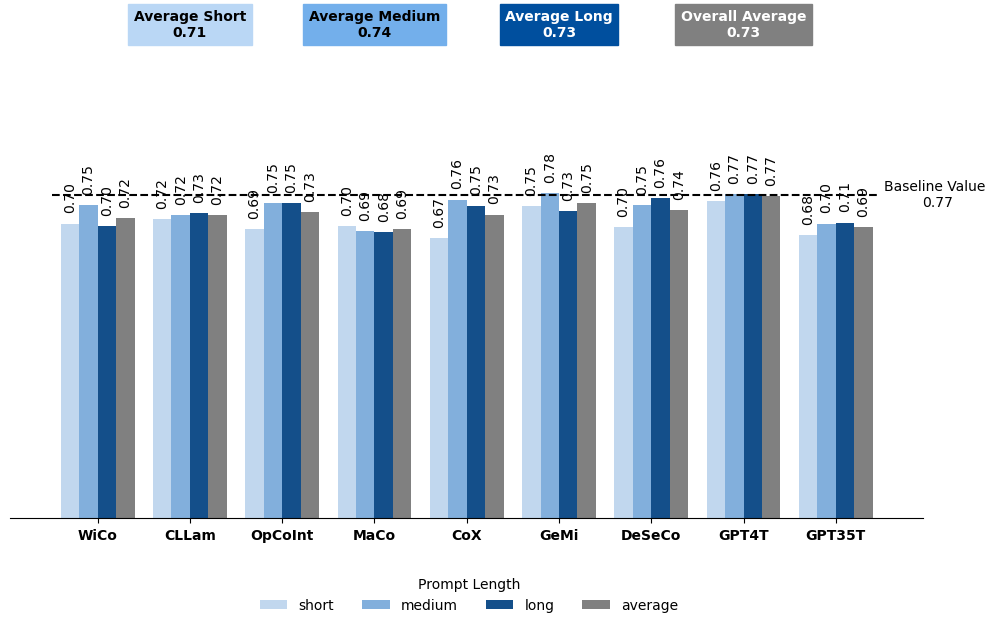

In [56]:
# Catplot
g = sns.catplot(data=df[df.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='composite',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=None
                )

baseline_value = df[df.model == 'Base']['composite'].values[0]
short_average = df[df.prompt == 'short']['composite'].mean()
medium_average = df[df.prompt == 'medium']['composite'].mean()
long_average = df[df.prompt == 'long']['composite'].mean()
overall_average = df[df.prompt == 'average']['composite'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.15, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.15, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.15, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.15, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


# Reliability

In [7]:
# Partition dataframes for maintainability
df_reliability = partion(df, reliability_metrics)
df_domain_reliability = partion(domain_df, reliability_metrics, domain=True)

## Halstead Bugs and Complexity per Methods

### Domain Exploration

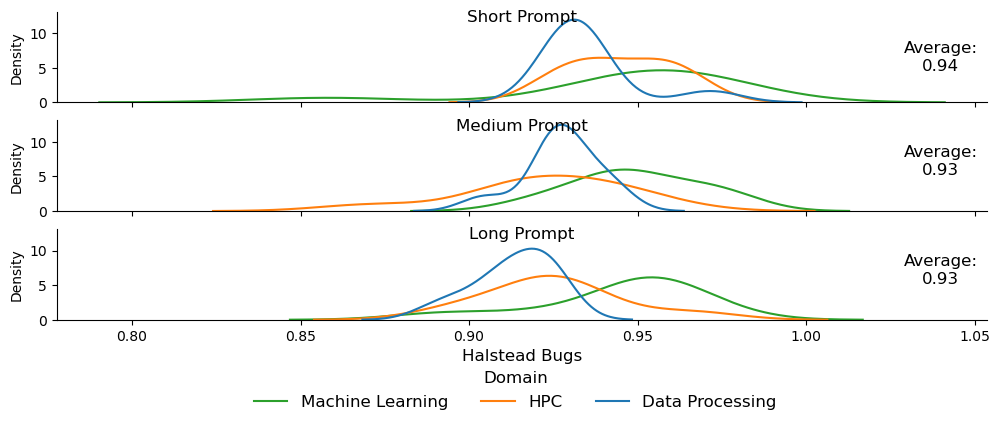

In [9]:
#df_domain_reliability = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_reliability[df_domain_reliability.prompt == prompt], x='halstead_bugs', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light', y=0.8)
    axs[i].set_xlabel('Halstead Bugs', fontsize=12)
    axs[i].text(0.95, distance, f"Average:\n{df_domain_reliability[df_domain_reliability.prompt == prompt]['halstead_bugs'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

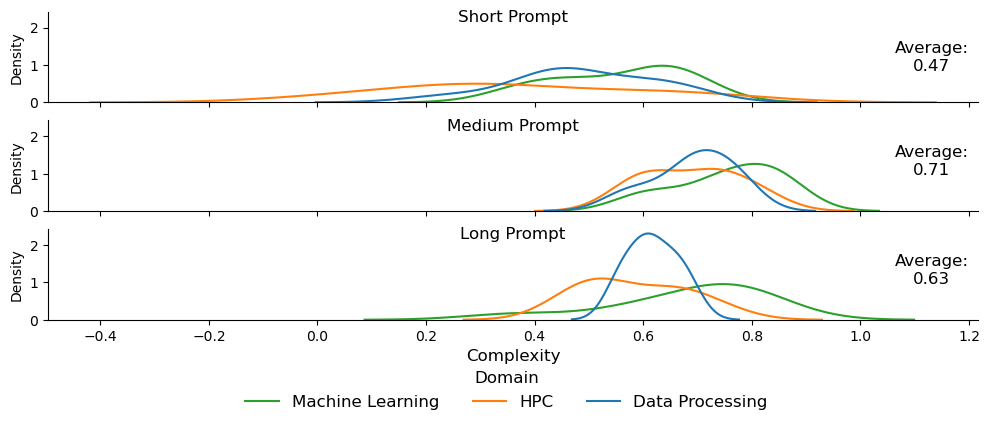

In [10]:
#df_domain_reliability = df_raw[['domain','prompt','loc', 'model']].groupby(['domain', 'model','prompt']).agg(np.mean).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)

# Plot the maintainability index for each prompt
for i, (prompt, distance) in enumerate(zip(['short', 'medium', 'long'], [0.5, -0.65, -1.85])):
    sns.kdeplot(data=df_domain_reliability[df_domain_reliability.prompt == prompt], x='max_complexity', ax=axs[i], hue='domain', color=domain_palette, legend=False)
    axs[i].set_title(f'{prompt.capitalize()} Prompt', fontweight='light', y=0.8)
    axs[i].set_xlabel('Complexity', fontsize=12)
    axs[i].text(0.95, distance, f"Average:\n{df_domain_reliability[df_domain_reliability.prompt == prompt]['max_complexity'].mean():.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=12)


axs[0].legend(loc='upper right', bbox_to_anchor=(.79, -2.8), ncol=3, title='Domain', labels=['Machine Learning', 'HPC', 'Data Processing'], title_fontsize='large', fontsize='large', frameon=False)

sns.despine()
plt.show()

### Model Exploration

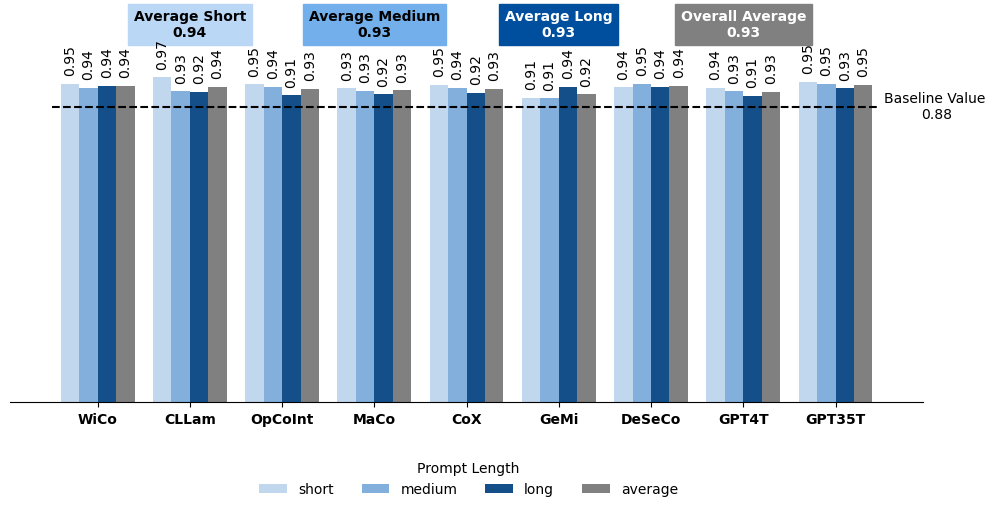

In [129]:
# Catplot
g = sns.catplot(data=df_reliability[df_reliability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='halstead_bugs',
                hue='prompt',
                palette=prompt_palette,
                legend=False
                )

baseline_value = df_reliability[df_reliability.model == 'Base']['halstead_bugs'].values[0]
short_average = df_reliability[df_reliability.prompt == 'short']['halstead_bugs'].mean()
medium_average = df_reliability[df_reliability.prompt == 'medium']['halstead_bugs'].mean()
long_average = df_reliability[df_reliability.prompt == 'long']['halstead_bugs'].mean()
overall_average = df_reliability[df_reliability.prompt == 'average']['halstead_bugs'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


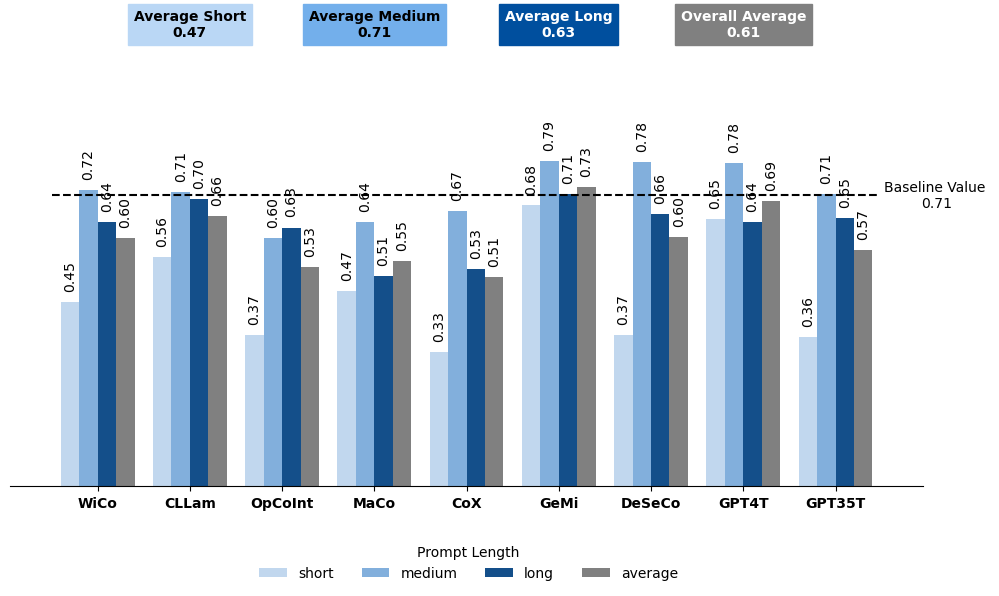

In [131]:
# Catplot
g = sns.catplot(data=df_reliability[df_reliability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='max_complexity',
                hue='prompt',
                palette=prompt_palette,
                legend=False
                )

baseline_value = df_reliability[df_reliability.model == 'Base']['max_complexity'].values[0]
short_average = df_reliability[df_reliability.prompt == 'short']['max_complexity'].mean()
medium_average = df_reliability[df_reliability.prompt == 'medium']['max_complexity'].mean()
long_average = df_reliability[df_reliability.prompt == 'long']['max_complexity'].mean()
overall_average = df_reliability[df_reliability.prompt == 'average']['max_complexity'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


In [134]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_reliability.pivot(index='model',columns='prompt',values='max_complexity')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
dfi.export(bugs_style, 'results_output/max_complexity.png')

In [135]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_reliability.pivot(index='model',columns='prompt',values='halstead_bugs')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
dfi.export(bugs_style, 'results_output/halstead_bugs.png')

### Python Specific Reliability

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_22550/3260987890.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.catplot(data=df_domain_reliability[-df_domain_reliability.prompt.isin(['baseline'])].sort_values(by='prompt',ascending=False),


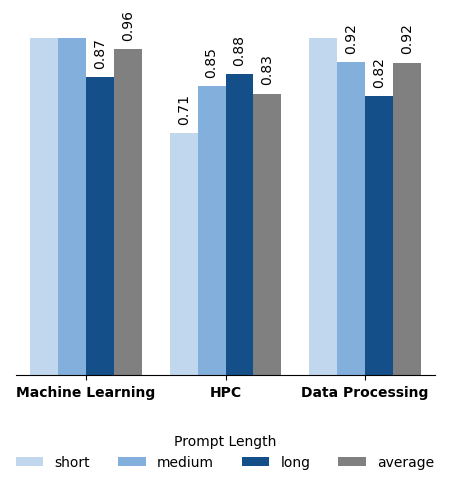

In [23]:
# Catplot
g = sns.catplot(data=df_domain_reliability[-df_domain_reliability.prompt.isin(['baseline'])].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='domain',
                y='errors',
                hue='prompt',
                palette=prompt_palette,
                legend=False,
                ci=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(5, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
g.figure.axes[0].set_ylim(0, 1)
# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


In [27]:
#bugs['halstead_bugs'] = bugs["halstead_bugs"].apply(lambda x: f'{x:.2f}')
bugs_style = df_reliability.pivot(index='model',columns='prompt',values='errors')
bugs_style['baseline'] = bugs_style['baseline'].ffill()
bugs_style = bugs_style[bugs_style.index != 'Base']
bugs_style = bugs_style[['short','medium','long','average', 'baseline']]
bugs_style = bugs_style.rename_axis(None, axis=1)
bugs_style = pd.concat([bugs_style, pd.DataFrame([bugs_style.mean().values], index=['Average'], columns=bugs_style.columns)], axis=0)
bugs_style = bugs_style.style.background_gradient(cmap='Blues', axis=None)
bugs_style = bugs_style.set_properties(**{'font-size': '14pt', 'font-family': 'Arial', 'text-align': 'center', 'height': '20px'})
bugs_style = bugs_style.format({col: "{:.2f}" for col in bugs_style.columns})
bugs_style = bugs_style.set_table_styles([dict(selector='th', props=[('font-size', '10pt'),('font-family', 'Arial'), ('width', '50px'), ('text-align', 'center'), ('height', '20px')]),])
bugs_style
dfi.export(bugs_style, 'results_output/errors.png')

### Composite Score

In [36]:
reliability_composite = lambda x: x['errors'] * 0.25 + x['halstead_bugs'] * 0.25 + x['max_complexity'] * 0.25 + x['warnings'] * 0.25
df_security['security'] = (df_security['security_low'] * 1/3) + (df_security['warnings'] * 1/3) + (df_security['errors'] * 1/3)
df_reliability['composite_score'] = reliability_composite(df_reliability)

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_22550/3767540078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reliability['composite_score'] = reliability_composite(df_reliability)


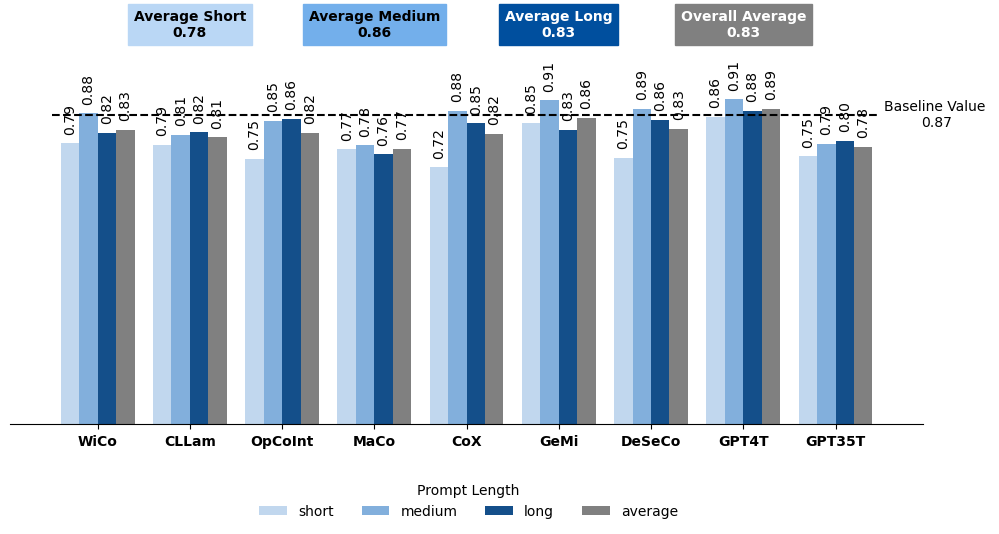

In [37]:
# Catplot
g = sns.catplot(data=df_reliability[df_reliability.model != 'Base'].sort_values(by='prompt',ascending=False),
                kind='bar',
                x='model',
                y='composite_score',
                hue='prompt',
                palette=prompt_palette,
                legend=False
                )

baseline_value = df_reliability[df_reliability.model == 'Base']['composite_score'].values[0]
short_average = df_reliability[df_reliability.prompt == 'short']['composite_score'].mean()
medium_average = df_reliability[df_reliability.prompt == 'medium']['composite_score'].mean()
long_average = df_reliability[df_reliability.prompt == 'long']['composite_score'].mean()
overall_average = df_reliability[df_reliability.prompt == 'average']['composite_score'].mean()

# Set labels, title and size
g.set_axis_labels("", "Value")
#g.figure.title('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches
g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), rotation=0, ha='center')

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 8.5, colors='black', linestyles='--')
g.figure.axes[0].text(9.1, baseline_value, f'Baseline Value \n{round(baseline_value,2)}', ha='center', va='center', backgroundcolor='w')#, weight='bold')

# Add average lines
g.figure.axes[0].text(1, 1.09, f'Average Short\n{short_average:.2f}', ha='center',weight='bold', backgroundcolor=prompt_palette['short'])
g.figure.axes[0].text(3, 1.09, f'Average Medium\n{medium_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['medium'])
g.figure.axes[0].text(5, 1.09, f'Average Long\n{long_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['long'], color='white')
g.figure.axes[0].text(7, 1.09, f'Overall Average\n{overall_average:.2f}', ha='center', weight='bold', backgroundcolor=prompt_palette['average'], color='white')

#g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks

# Set legend position
g.figure.legend(bbox_to_anchor=(0.55, -0.15), loc='lower center', ncol=4, frameon=False, title='Prompt Length')

g.figure.axes[0].spines['left'].set_visible(False)

# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03),
                  ha='center', va='center',
                  rotation=90, xytext=(0, 10),
                  textcoords='offset points')# , weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()


# Archived

In [ ]:
# Metrics used
reliability_metrics = ["Errors (E)", "Warnings (W)", "Cyclomatic Complexity", "Halstead Bugs"]
maintainability_metrics = ["Maintainability Index", "Refactoring Checks (R)", "Style Convenetion Errors (C)", "comments-to-lines", "SLOC/Methods"]
performance_metrics = ['Total Memory Usage (MiB)', 'CPU Usage Per Cent']
security_metrics = ["Warnings (W)", "Errors (E)", "Pylint Rating"]

# Unique metrics
metrics = list(set(reliability_metrics + maintainability_metrics + performance_metrics + security_metrics)) + ['Metric']
df0 = df0[metrics]

In [ ]:
# Scaling the data
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
scaling_metrics = df0.iloc[:, :-1].columns # ['Total Memory Usage (MiB)','Halstead Bugs','Style Convenetion Errors (C)', 'Warnings (W)', 'SLOC/Methods', 'Refactoring Checks (R)', 'Cyclomatic Complexity', 'Errors (E)']

# Normalize the metrics
normalized = scaler.fit_transform(df0[scaling_metrics])
df_normalized = pd.DataFrame(normalized, columns=scaling_metrics, index=df0.index)
df_normalized['Metric'] = df0['Metric']
# df_normalized.index = df.index

# Partitioning datasets
long = df_normalized[(df_normalized.Metric == "Long") | (df_normalized.Metric.isna())]
medium = df_normalized[(df_normalized.Metric == "Medium") | (df_normalized.Metric.isna())]
small = df_normalized[(df_normalized.Metric == "Small") | (df_normalized.Metric.isna())]


### Helpers

In [ ]:
# Partitioning dataframe into ISO 5055
def iso_partion(df:pd.DataFrame, metrics: list):
    return df[metrics]

In [ ]:
# Generate composite score
def composite_score(df, metrics, weights, negative = False):

    # Initialize the MinMaxScaler
    #scaler = MinMaxScaler()

    # Normalize the metrics
    # df_normalized = scaler.fit_transform(df[metrics])
    # df_normalized = pd.DataFrame(df_normalized, columns=metrics)
    # df_normalized.index = df.index
    #
    # Compute the composite score
    df['composite_score'] = df.apply(lambda x: sum(x[metric] * weight for metric, weight in weights.items()), axis=1)

    # If negative, then reverse the composite score
    if negative:
        df['composite_score'] = -df['composite_score']

    return df


In [ ]:
# palette = sns.color_palette(['red','green','blue'])#'#182787','#4754a8', '#818bcc'])
palette = sns.color_palette(['#3F92A8','#e2c222','#E43307'])#'#182787','#4754a8', '#818bcc'])

## ISO Partioning
See notion [here](https://www.notion.so/raskrebs/ISO-5055-Metric-Groupings-aabc91707db0428f91a2ffd4296b0814?pvs=4)

In [ ]:
# Model renaming
model_names = {"Codex":"Codex",
 "DeepSeeker-Coder":"DeSe-Co",
 "WizardCoder":"WiCo",
 "Tabnine":"T9",
 "GPT 4":"GPT4",
 "GPT 3.5":"GPT35",
 "Gemini/Bard":"Gemini",
 "CodeLLama":"CLLam",
 }

### Reliability

In [ ]:
def relaibility(df_length, version):
    # Relability Comsposite Score
    weights = {"Errors (E)": 0.25,
               "Warnings (W)": 0.25,
               "Cyclomatic Complexity": 0.3,
               "Halstead Bugs": 0.2}


    metrics = weights.keys()

    assert sum(weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(weights.values()))

    # Maintainability long
    df = df_length[metrics]

    # Subtracting from 1, such that the higher the score, the better
    for metric in metrics:
        df[metric] =  1 - df[metric]

    # Compute the composite score
    df = composite_score(df,
                         metrics,
                         weights)
    # Resetting index
    df['model'] = df.index
    df = df.reset_index(drop=True)

    # Sorting by composite score
    df = df.sort_values(by="composite_score", ascending=False)
    df['version'] = version

    return df

In [ ]:
# Transform
long_relaibility = relaibility(long, 'long')
medium_relaibility = relaibility(medium, 'medium')
small_relaibility = relaibility(small, 'small')

In [ ]:
# Concatenating the data
concat_columns = ['model', 'version', 'composite_score']
relaibility_plot_data = pd.concat([long_relaibility[concat_columns], medium_relaibility[concat_columns], small_relaibility[concat_columns]])
relaibility_plot_data = relaibility_plot_data[relaibility_plot_data.model != 'Baseline']
relaibility_plot_data.model = relaibility_plot_data.model.map(model_names)
baseline_value = long_relaibility[long_relaibility.model == 'Baseline'].composite_score.values[0]

# Plotting
g = sns.catplot(data=relaibility_plot_data,
                kind='bar',
                x='model',
                y='composite_score',
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, baseline_value, f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
#g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()

### Maintainability

In [ ]:
def maintainability(df_length, version):
    # Weights for maintainability composite score
    weights = {
        'Refactoring Checks (R)': 0.25,  # Low severity
        'Style Convenetion Errors (C)': 0.15,  # Low severity
        "comments-to-lines": .2, # The higher the ratio, the better the maintainability as more documentation is provided
        "SLOC/Methods": 0.2, # High ratio indicates low maintainability as they are likely then more complex and harder to maintain
        'Maintainability Index': 0.2  # Direct measure of maintainability, so just balanced. It's not given a higher weights since MIs between 60-100 are generally considered good
        }


    metrics = weights.keys()

    assert sum(weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(weights.values()))

    # Maintainability long
    df = df_length[metrics]

    # Maintainability specific preprocessing: Invert all scores, where closer to zero is better
    # df['Refactoring Checks (R)'] *= -1
    # df['Style Convenetion Errors (C)'] *= -1
    # df['SLOC/Methods'] *= -1
    df['Refactoring Checks (R)'] = 1 - df['Refactoring Checks (R)']
    df['Style Convenetion Errors (C)'] = 1 - df['Style Convenetion Errors (C)']
    df['SLOC/Methods'] = 1 - df['SLOC/Methods']


    # Compute the composite score
    df = composite_score(df,
                         metrics,
                         weights)

    # Resetting index
    df['model'] = df.index
    df = df.reset_index(drop=True)

    # Sorting by composite score
    df = df.sort_values(by="composite_score", ascending=False)
    df['version'] = version

    return df

In [ ]:
# Compute the composite score
maintainability_long = maintainability(long, 'long')
maintainability_medium = maintainability(medium, 'medium')
maintainability_small = maintainability(small, 'small')

In [ ]:
# Concatenating the data
maintainability_plot_data = pd.concat([maintainability_long[concat_columns], maintainability_medium[concat_columns], maintainability_small[concat_columns]])
maintainability_plot_data = maintainability_plot_data[maintainability_plot_data.model != 'Baseline']
baseline_value = maintainability_long[maintainability_long.model == 'Baseline'].composite_score.values[0]
maintainability_plot_data.model = maintainability_plot_data.model.map(model_names)

# Plotting
g = sns.catplot(data=maintainability_plot_data,
                kind='bar',
                x='model',
                y='composite_score',
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Maintainability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(maintainability_long[maintainability_long.model == 'Baseline'].composite_score.values[0], -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, maintainability_long[maintainability_long.model == 'Baseline'].composite_score.values[0], f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
#g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()

### Performance Efficiency

In [ ]:
def performance(length, version):
    # Weights for performance composite score
    weights = {
        'Total Memory Usage (MiB)' : 0.5,
        'CPU Usage Per Cent' : 0.5}

    metrics = weights.keys()

    assert sum(weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(weights.values()))

    # Maintainability long
    df = length[metrics]

    # Invert the CPU Usage Per Cent to ensure higher scores indicate better performance
    df['CPU Usage Per Cent'] = 1 - df['CPU Usage Per Cent']
    df['Total Memory Usage (MiB)'] = 1 - df['Total Memory Usage (MiB)']

    # Compute the composite score
    df = composite_score(df,
                         metrics,
                         weights)

    # Resetting index
    df['model'] = df.index
    df = df.reset_index(drop=True)

    # Sorting by composite score
    df = df.sort_values(by="composite_score", ascending=False)
    df['version'] = version

    return df

In [ ]:
# Compute the composite score
performance_long = performance(long, 'long')
performance_medium = performance(medium, 'medium')
performance_small = performance(small, 'small')

In [ ]:

performance_plot_data = pd.concat([performance_long[concat_columns], performance_medium[concat_columns], performance_small[concat_columns]])
performance_plot_data = performance_plot_data[performance_plot_data.model != 'Baseline']
baseline_value = performance_long[performance_long.model == 'Baseline'].composite_score.values[0]
performance_plot_data.model = performance_plot_data.model.map(model_names)

# Plotting
g = sns.catplot(data=performance_plot_data,
                kind='bar',
                x='model',
                y='composite_score',
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Performance', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(performance_long[performance_long.model == 'Baseline'].composite_score.values[0], -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, performance_long[performance_long.model == 'Baseline'].composite_score.values[0], f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
#g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()

### Security
*Static code checks can indirectly relate to security by encouraging good coding practices that can prevent certain types of vulnerabilities, but generally these are only indicative. Security is overall difficult to test for using only static code analysis*

In [ ]:
def security(df_length, version):
    # Weights for security composite score.
    security_weights = {
        "Warnings (W)": .3,
        "Errors (E)": .3,
        "Pylint Rating": .4,
    }


    # Metrics from long to include
    security_metrics = security_weights.keys()

    assert sum(security_weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(security_weights.values()))

    # Security long
    df = df_length[security_metrics]

    # Invert the negative scores, such that these negatively influence the rating
    df['Warnings (W)'] = 1 - df['Warnings (W)']
    df['Errors (E)'] = 1 - df['Errors (E)']


    # Compute the composite score
    df = composite_score(df,
                                   security_metrics,
                                   security_weights)

    # df['composite_score'] /= 3

    # Assign model to column rather than index
    df['model'] = df.index
    df = df.reset_index(drop=True)

    # Add version
    df['version'] = version

    return df

In [ ]:
security_long = security(long,'long')
security_medium = security(medium,'medium')
security_small = security(small,'small')

In [ ]:

# fig, axs = plt.subplots(figsize=(11, 4))
security_plot_data = pd.concat([security_long[concat_columns], security_medium[concat_columns], security_small[concat_columns]])
security_plot_data = security_plot_data[security_plot_data.model != 'Baseline']
baseline_value = security_long[security_long.model == 'Baseline'].composite_score.values[0]
security_plot_data.model = security_plot_data.model.map(model_names)

# Plotting
g = sns.catplot(data=security_plot_data,
                kind='bar',
                x='model',
                y='composite_score',
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Security', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(security_long[security_long.model == 'Baseline'].composite_score.values[0], -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, security_long[security_long.model == 'Baseline'].composite_score.values[0], f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')
# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()